In [29]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import fitsio
import glob

from sklearn.decomposition import SparsePCA, FastICA, PCA

import sys
sys.path.append("../")
import pyrosl

from astropy.convolution import convolve, Gaussian2DKernel
from SPyFFI.Cosmics import cosmicImage
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(16.0,9.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 150             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


In [2]:
# ls /Users/benjaminpope/Data/tess/ete6

In [3]:
f = fitsio.FITS('/Users/benjaminpope/Data/tess/ete6/tess2019129080826-4-2-0016-s_ffic.fits')
# tpf = KeplerTargetPixelFile.from_archive(2568982,quarter=3)
raw_fluxes = np.copy(f[1][:,:])
# m = np.isfinite(raw_fluxes[0,:,:])
# fluxes = raw_fluxes[:,m] # axis 1 is pixels, axis 0 is individual time series

In [4]:
filenames = glob.glob('/Users/benjaminpope/Data/tess/ete6/*.fits')

In [5]:
%%time
f = fitsio.FITS(filenames[0])
shape = f[1][:,:].shape

x0, xm = 128,128+64
y0, ym = 128,128+64

data = np.zeros((len(filenames),xm-x0,ym-y0))


for j, fname in enumerate(filenames):
    if j %  100 == 0:
        print j
    f = fitsio.FITS(filenames[j])
    data[j,:,:] = f[1][x0:xm,y0:ym]
    
print 'Finished'

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Finished
CPU times: user 435 ms, sys: 219 ms, total: 654 ms
Wall time: 652 ms


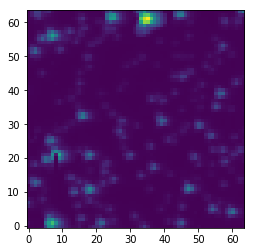

In [6]:
plt.imshow(np.log10(np.nanmean(data,axis=0)),interpolation=None)

In [16]:
X = np.log10(data).reshape((data.shape[0],data.shape[1]*data.shape[2])) # with noise
# X = dat.reshape((n_samples,nx*ny)) # no noise

# X /= X.max()


In [17]:
# Parameters for ROSL
regROSL = 2
estROSL = 10

# Parameters for ROSL+
regROSLp = 0.01
estROSLp = 10
samplesp = (250, 250)


In [18]:
# Run the full version
print ' '
full_rosl = pyrosl.ROSL(
    method = 'full',
    rank = estROSL,
    reg = regROSL,
    verbose = True
   )


In [19]:
%%time
loadings, components, E = full_rosl._fit(X)
loadings = loadings[:, :full_rosl.rank_]
model = np.dot(loadings, full_rosl.components_)
sparse = E.reshape(np.shape(data))
lowrank = model.reshape(np.shape(data))

print 'Rank found',full_rosl.rank_


Array must be in Fortran-order. Converting now.
Rank found 10
CPU times: user 16.8 s, sys: 2.31 s, total: 19.1 s
Wall time: 11 s


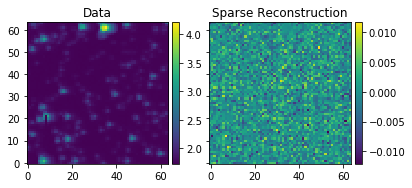

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(np.log10(data)[index,:,:])
ax1.set_title('Data')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(sparse[index,:,:])
ax2.set_title('Sparse Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


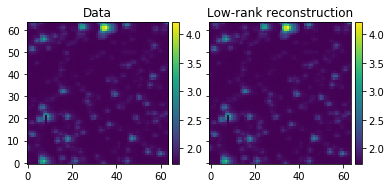

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(np.log10(data)[index,:,:])
ax1.set_title('Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(lowrank[index,:,:])
ax2.set_title('Low-rank reconstruction')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


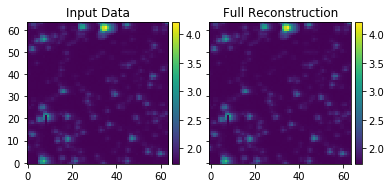

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3

im1 = ax1.imshow(np.log10(data)[index,:,:])
ax1.set_title('Input Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow((sparse+lowrank)[index,:,:])
ax2.set_title('Full Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


In [34]:
data[0,:,:]-data[1,:,:]

array([[ 0.86814117, -0.13318253,  0.25018692, ...,  0.53458786,
        -0.46113968,  0.43112946],
       [ 0.3229599 ,  0.05076218, -0.11138916, ...,  0.71744537,
         0.25875473,  0.63211441],
       [-1.36652374,  0.5941124 ,  0.79621124, ...,  0.54808044,
         0.44746399,  0.24791718],
       ...,
       [-0.42731857,  0.82678986,  2.84077454, ..., -1.47187042,
        -3.47784424, -1.63252258],
       [ 1.26144791,  1.16699982,  2.74797058, ...,  0.39536285,
         4.64254761,  6.52146149],
       [ 1.06403732,  1.61695862,  1.23860168, ...,  7.11168671,
        13.88742065, 26.84597778]])

In [51]:
def all_plots(index,f):

    im1 = ax1.imshow((np.log10(data)-np.log10(np.nanmedian(data,axis=0)))[index,:,:])
    ax1.set_title('Input Data')

#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im1,cax=cax)

    im2 = ax2.imshow((sparse)[index,:,:])
    ax2.set_title('Sparse')
#     divider2 = make_axes_locatable(ax2)
#     cax2 = divider2.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im2,cax=cax2)

#     divider3 = make_axes_locatable(ax3)
#     cax3 = divider3.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im3,cax=cax3)

    im3 = ax3.imshow((lowrank-np.log10(np.nanmedian(data,axis=0)))[index,:,:])
    ax3.set_title('Low Rank')



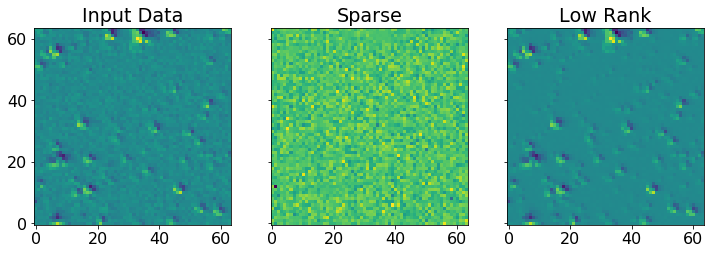

In [52]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(12.0,9.0))

all_plots(0,f)

In [53]:
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)


0
10
20
30
40
50
60
70
80
90
Saved to e2e_video.mp4
CPU times: user 2min 50s, sys: 10 s, total: 3min
Wall time: 2min 14s


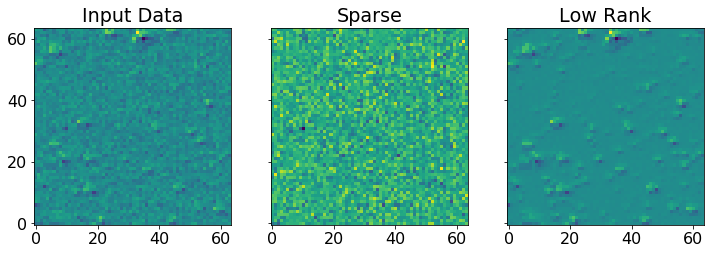

In [54]:
%%time 
plt.rcParams["animation.html"] = "jshtml"
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(12.0,9.0))

with writer.saving(f, "e2e_video.mp4", 100):

    for i in range(100):
        if i % 10 == 0:
            print i 
        all_plots(i,f)
        writer.grab_frame()
print 'Saved to e2e_video.mp4'

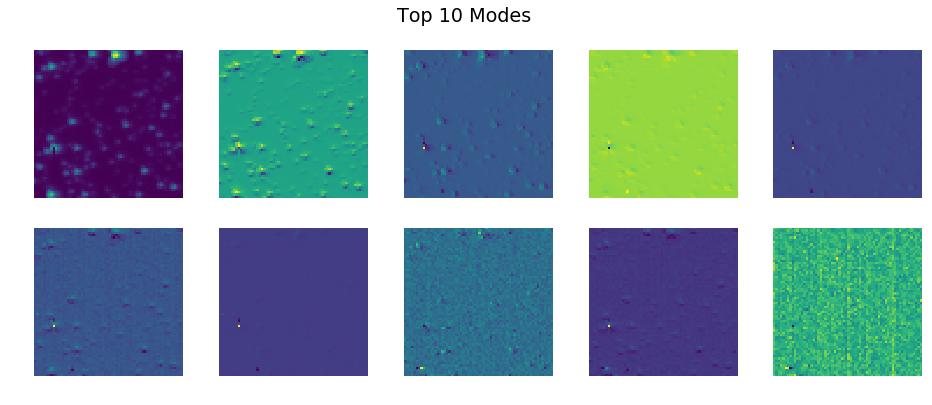

In [64]:
f, axes = plt.subplots(2,5,figsize=(16.0,6.0))
f.suptitle('Top 10 Modes')
for j in range(10):
    axes.ravel()[j].imshow((full_rosl.components_[j,:]).reshape((xm-x0,ym-y0)),interpolation='None')
    axes.ravel()[j].axis('off')
plt.savefig('pca_modes_tess.png',bbox_inches='tight')

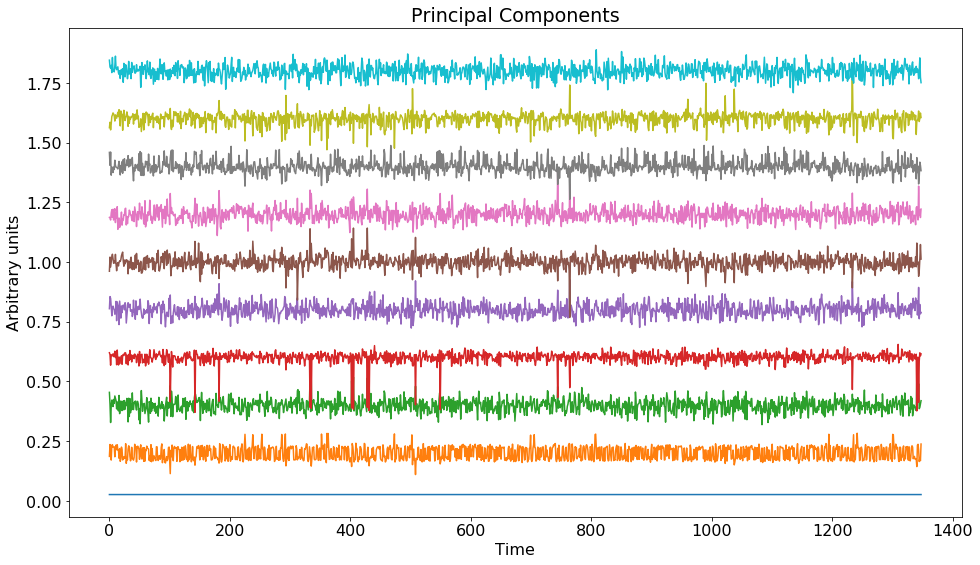

In [70]:
for j in range(10):
    plt.plot((loadings[:,j])/(1+np.nanmedian(loadings[:,j]))+j/5.)
    
plt.title('Principal Components')
plt.xlabel('Time')
plt.ylabel('Arbitrary units')
plt.savefig('loadings_tess.png',bbox_inches='tight')